# Diabetes Challenge

## Synopsis

This file contains

## Requirements

Let us first load the libraries that are required for our analysis task.

In [27]:
# Credentials
import os
from dotenv import load_dotenv

# Data retrieving and processing
import psycopg2
import pandas as pd
import csv

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn Tools
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings


## Global Configs

Next, let us specify all required "global configs" to have them in one place.

In [28]:
warnings.filterwarnings("ignore")

PATH_DATA_TRAIN = "./data/train.csv"
PATH_DATA_TEST = "./data/test.csv"

try:
    plt.style.use("foo")
except:
    pass

We read the data from file into a pandas data frame and create a copy that will incorporate our manipulations.

In [34]:
df_0 = pd.read_csv(PATH_DATA_TRAIN)

df_1 = df_0.copy()

Due to joining, we have some column duplicates:

In [35]:
# Compare with the "About" section in
# <https://zindi.africa/competitions/flight-delay-prediction-challenge/data>

df_1 = df_1.rename(columns={
    "ID": "row_no", 
    "DATOP": "date_of_flight",
    "FLTID": "flight_id",
    "DEPSTN": "departure_point",
    "ARRSTN": "arrival_point",
    "STD": "scheduled_time_departure",
    "STA": "scheduled_time_arrival",
    "STATUS": "flight_status",
    "AC": "aircraft_code",
})


Let us drop them now.

In [31]:
# cols_to_drop = [col for col in df_1.columns if "." in col]

# df_1 = df_1.drop(columns=cols_to_drop)

In [36]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   row_no                    107833 non-null  object 
 1   date_of_flight            107833 non-null  object 
 2   flight_id                 107833 non-null  object 
 3   departure_point           107833 non-null  object 
 4   arrival_point             107833 non-null  object 
 5   scheduled_time_departure  107833 non-null  object 
 6   scheduled_time_arrival    107833 non-null  object 
 7   flight_status             107833 non-null  object 
 8   aircraft_code             107833 non-null  object 
 9   target                    107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [38]:
df_1["row_no"] = df_1["row_no"].str.replace("train_id_","").astype(int)

df_1

,row_no,date_of_flight,flight_id,departure_point,arrival_point,scheduled_time_departure,scheduled_time_arrival,flight_status,aircraft_code,target
0,0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [ ]:
df_1["row_no"] = df_1[""]

# Convert to datetime

df_1["date_of_flight"] = pd.to_datetime(df_1["date_of_flight"], format='%Y-%m-%d')

df_1["scheduled_time_departure"] = pd.to_datetime(df_1["scheduled_time_departure"], format='%Y-%m-%d %H:%M:%S')

df_1["scheduled_time_arrival"] = pd.to_datetime(df_1["scheduled_time_arrival"], format='%Y-%m-%d %H.%M.%S')


In [176]:
df_1.nunique()

id                          768
Age                          52
pregnancies                  17
bmi                         248
insulin                     220
glucose                     200
bloodpressure               123
patientid                   768
measurement_date              2
diabetespedigreefunction    517
outcome                       2
skinthickness                51
dtype: int64

The feature "measurement_date" is suspicious: Besides from the fact that its data type is not date, only two distinct values arise. and there are twice as many ids as patient ids

Let us look at the data via pair plot

In [20]:
sns.pairplot(
    df_1.drop(columns=["id", "patientid"]),
    # hue="Class",
    # palette="dark",
    # diag_kind="auto",
)

plt.show()

df_1

KeyError: "['id', 'patientid'] not found in axis"

It is a bit surprising that 

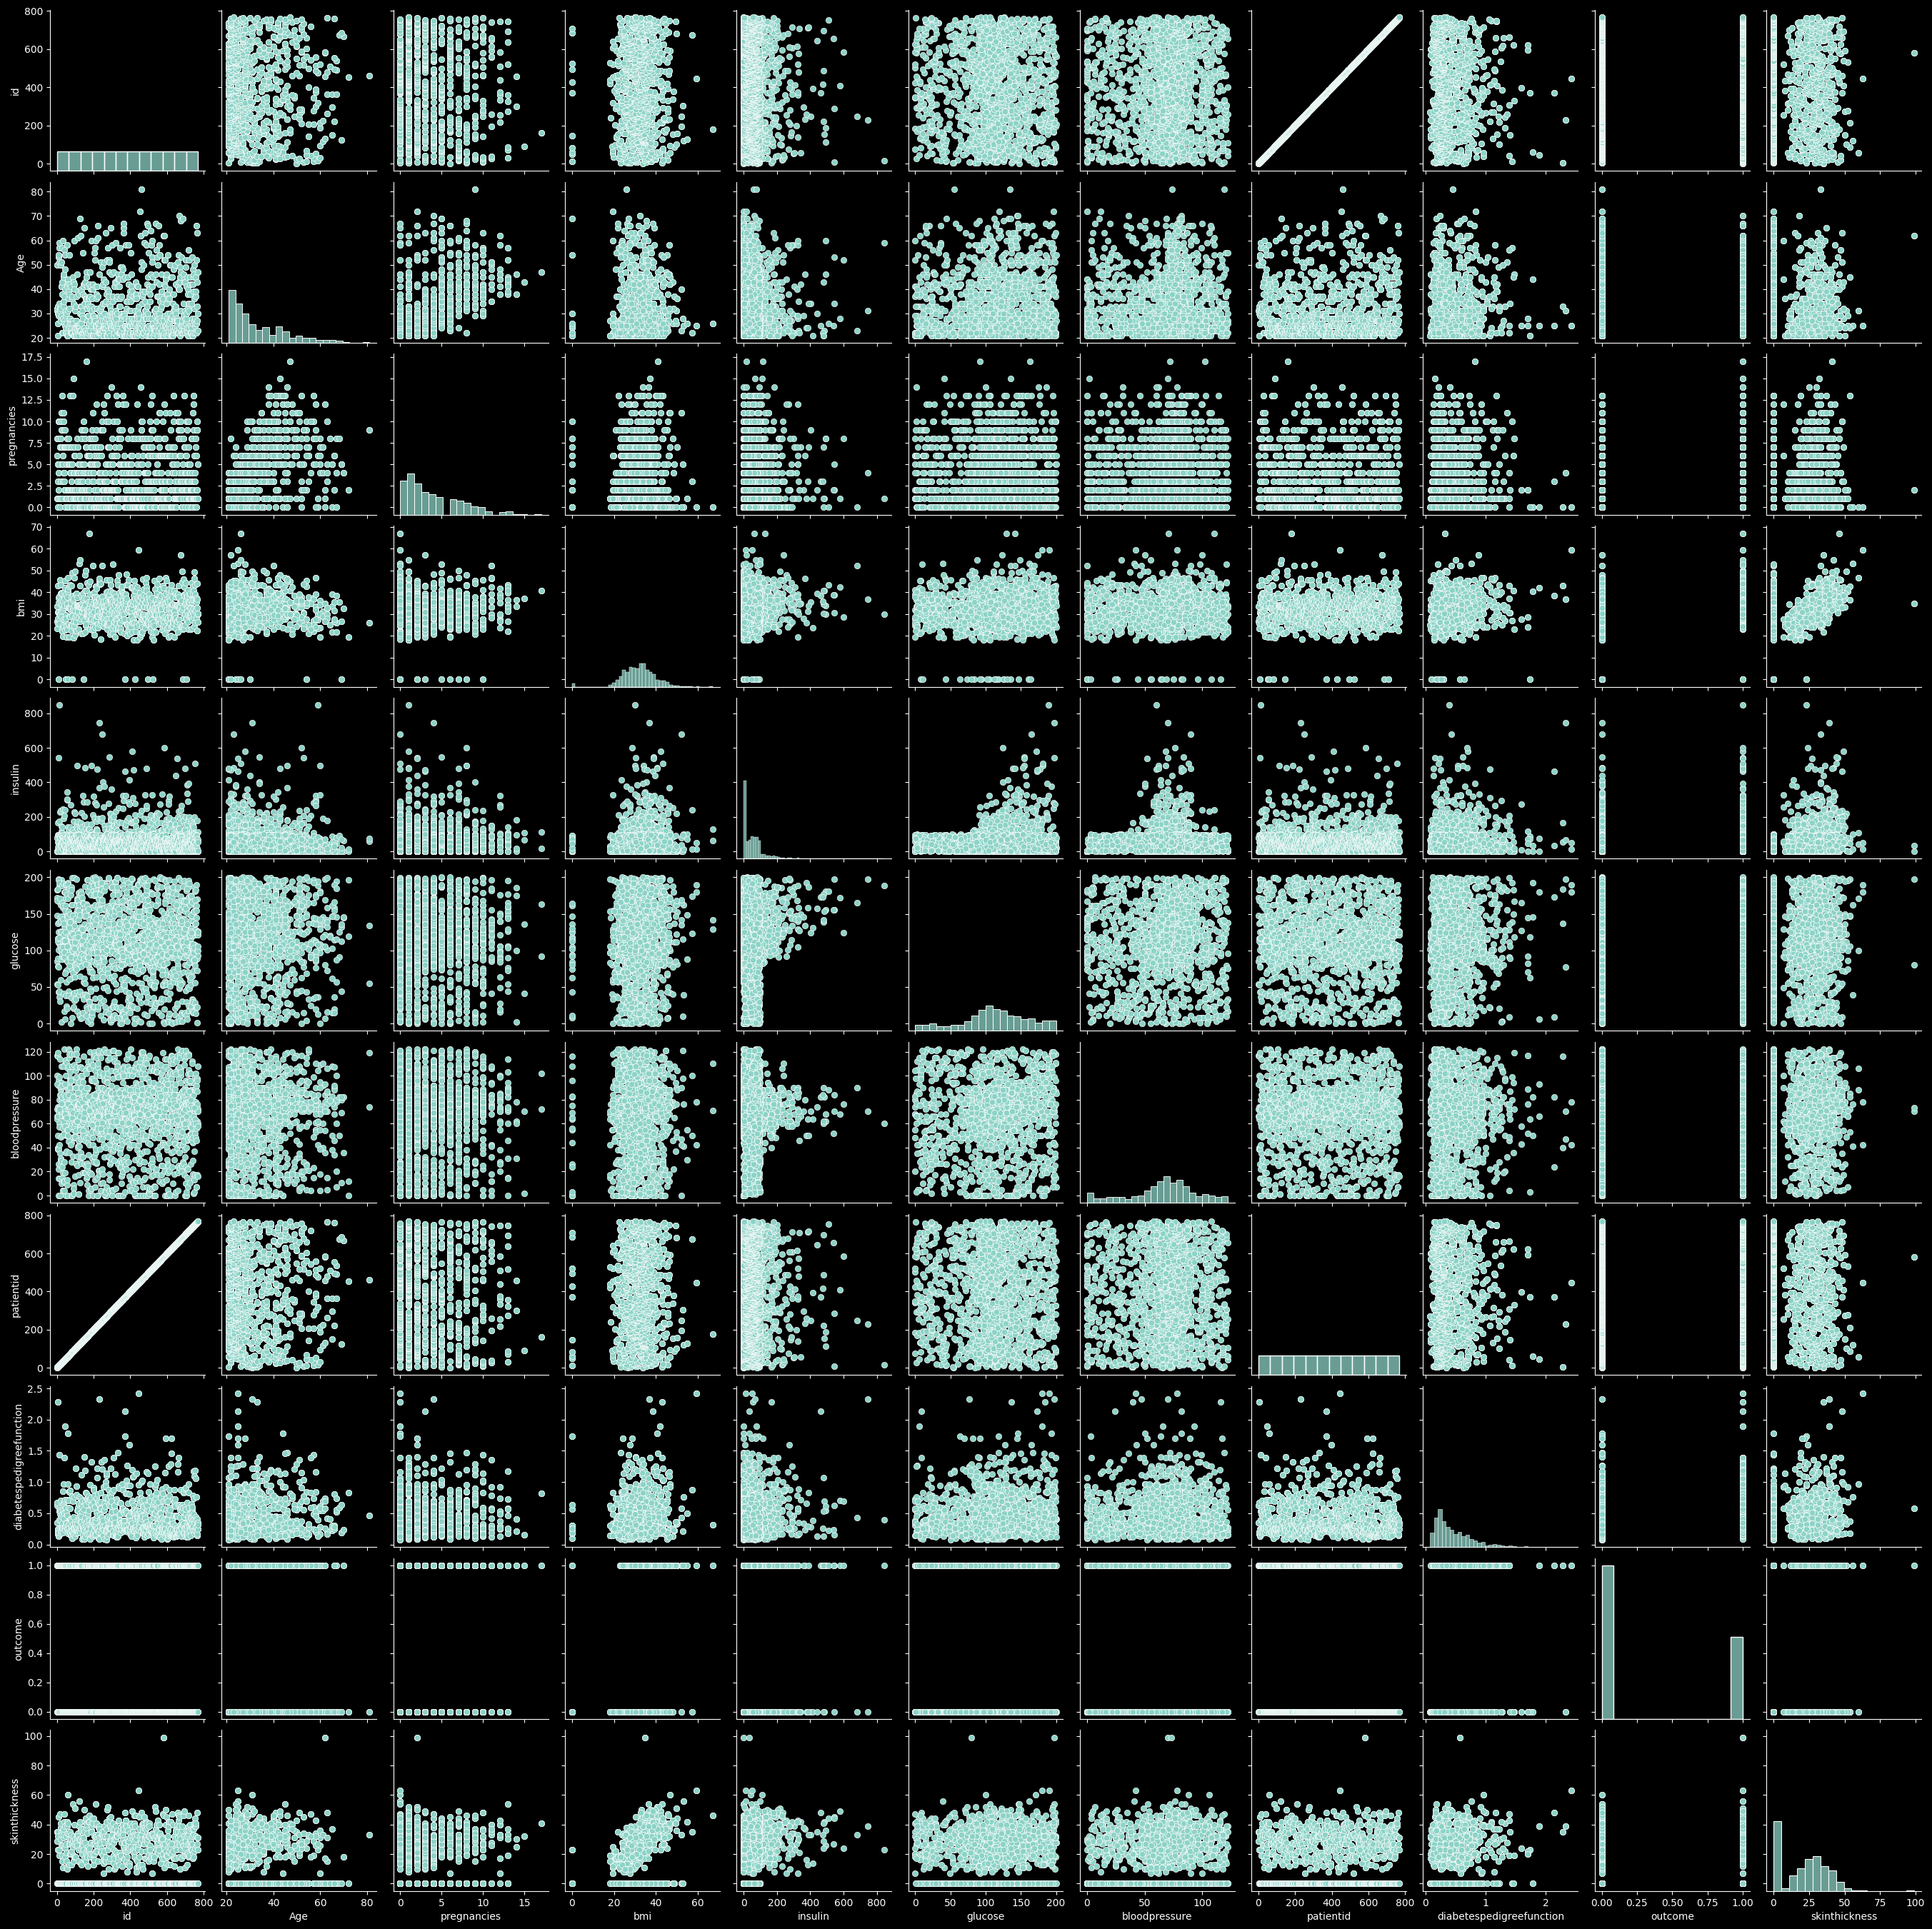

In [180]:
sns.pairplot(
    df_1,
    # hue="Class",
    # palette="dark",
    diag_kind="auto",
)

plt.show()

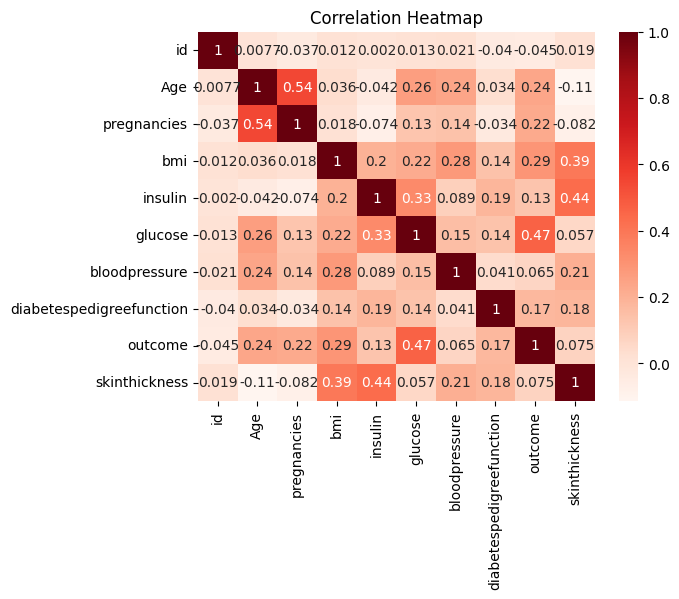

In [ ]:
cols_to_drop = [col for col in df_1.columns if col == "measurement_date"]

df_1 = df_1.drop(columns=cols_to_drop)

# df_1["outcome"].plot(kind="hist")
correlation_matrix = df_1.corr()
# Create the heatmap using seaborn
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Reds",
    linecolor="black",  # Black grid lines
)

# Add labels and title
plt.title("Correlation Heatmap")
plt.show()

Run Logistic Regression

In [ ]:
y_col = "outcome"

# TODO Separate in continuous vs. discrete
X_cols = [col for col in df_1.columns if col != y_col]

preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), X_cols)],
    remainder="passthrough",
)

logreg_pip = Pipeline(
    [("preprocessing", preprocessor), ("logreg", LogisticRegression())]
)

X = df_1[X_cols]
y = df_1[y_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

logreg_pip.fit(X_train, y_train)
y_pred = logreg_pip.predict(X_test)

Now predict

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.75
Confusion Matrix:
[[79 20]
 [18 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



And now the same for another classifier, namely a decision tree.

In [133]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), X_cols),
        # ("cat", OneHotEncoder(), ["gender"]),
    ],
    remainder="passthrough",
)

dtree_pipe = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("classifier", DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]
)

X = df_1[X_cols]
y = df_1[y_col]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

dtree_pipe.fit(X_train, y_train)
y_pred = dtree_pipe.predict(X_test)

Now, the results:

In [134]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Accuracy: 0.76
Confusion Matrix:
[[83 16]
 [21 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        99
           1       0.68      0.62      0.65        55

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

